# Embedding with Word2Vec

In [2]:
import sys
import os

# Install packages using os.system() with sys.executable to ensure correct environment
os.system(f"{sys.executable} -m pip install -q numpy pandas matplotlib seaborn scikit-learn")


0

In [4]:
os.system(f"{sys.executable} -m pip install gensim")
os.system(f"{sys.executable} -m pip install portalocker>=2.0.0")
os.system(f"{sys.executable} -m pip install torch==2.2.2")
os.system(f"{sys.executable} -m pip install torchdata==0.7.1")
os.system(f"{sys.executable} -m pip install torchtext==0.17.2")

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


0

In [8]:
#Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

from IPython.core.display import display, SVG


from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import Dataset


import logging
from gensim.models import Word2Vec
from collections import defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import GloVe,vocab
from torchdata.datapipes.iter import IterableWrapper, Mapper
from torchtext.datasets import AG_NEWS
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
from torchtext.data.utils import get_tokenizer
from torch.utils.data import DataLoader
from tqdm import tqdm

%matplotlib inline

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

## Define functions for working with word embeddings

In [21]:
# Define a function to plot word embeddings in a 2D space

def plot_embeddings(word_embeddings,vocab=vocab):
    # Reduce 300D embeddings to 2D using t-SNE
    tsne = TSNE(n_components=2, random_state=0)
    word_embeddings_2d = tsne.fit_transform(word_embeddings)

    # Plotting the results with labels from vocab
    plt.figure(figsize=(15, 15))
    for i, word in enumerate(vocab.get_itos() ):  # assuming vocab.itos gives the list of words in your vocab
        plt.scatter(word_embeddings_2d[i, 0], word_embeddings_2d[i, 1])
        plt.annotate(word, (word_embeddings_2d[i, 0], word_embeddings_2d[i, 1]))

    plt.xlabel("t-SNE component 1")
    plt.ylabel("t-SNE component 2")
    plt.title("Word Embeddings visualized with t-SNE")
    plt.show()

In [47]:
#Defines a similar words finder function that returns mostly similar words by calculating vector Cosine similrity 

'''
This code is needed to test
if the Word2Vec model has learned 
meaningful semantic relationships
'''

def find_similar_words(word, word_embeddings, top_k=5):
    if word not in word_embeddings:
        print("Word not found in embeddings.")
        return []
    target_embedding = word_embeddings[word]
    similarities = {}
    for w, embedding in word_embeddings.items():
        if w != word:
            similarity = torch.dot(target_embedding, embedding) / (
                torch.norm(target_embedding) * torch.norm(embedding)
            )
            similarities[w] = similarity.item()
    sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    most_similar_words = [w for w, _ in sorted_similarities[:top_k]]
    return most_similar_words


In [48]:
#Function that trains the word2vec model on sample data

def train_model(model, dataloader, criterion, optimizer, num_epochs=1000):
    epoch_losses = []
    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0
        for idx, samples in enumerate(dataloader):
            optimizer.zero_grad()
            
            # Check for EmbeddingBag layer in the model
            if any(isinstance(module, nn.EmbeddingBag) for _, module in model.named_modules()):
                target, context, offsets = samples
                predicted = model(context, offsets)
            
            # Check for Embedding layer in the model
            elif any(isinstance(module, nn.Embedding) for _, module in model.named_modules()):
                target, context = samples
                predicted = model(context)
                
            loss = criterion(predicted, target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()
            running_loss += loss.item()
        epoch_losses.append(running_loss / len(dataloader))
    
    return model, epoch_losses

## Summary

- Word2Vec is a method that transforms words into number vectors, positioning similar words close together in vector space defined by these numbers, allowing quantification of word relationships mathematically.
- There are many algorithms for learning word embeddings include GloVe (Global Vectors for Word Representation) that you can also explore further

In [15]:
sample_data = """I hope I become much more creative
I hope I become a leader
He wore a dark blue jacket to the meeting
The cat stalked a bright orange butterfly in the garden
She had a wide grin on her face when she passed the test
The small rabbit hopped around a colorful stuffed elephant
The group celebrated their achievement with a festive dinner
He bought a large, elegant watch for his father
The ocean waves crashed powerful and strong against the rocky shore
The student took long, confident strides as he walked to class
The apartment had a modern kitchen with a sleek marble counter
She felt a wave of excitement after finishing the important presentation
The baker created a rich, savory pastry using organic ingredients
The teenagers laughed loudly in the bright, spacious cafeteria
The movie had a profound effect on viewers across the globe
The rain fell steadily, washing the dust from the ancient buildings
He sketched a detailed, complex portrait on the large easel
The theater was packed with hundreds of eager spectators
The library was decorated with leather books of various themes
I plan to find true happiness in my personal relationships
The lighthouse stood majestically above the harbor, shining its beacon
She stared in wonder at the magnificent sunset from the balcony
The sculptor carved a remarkable statue with precise chisel work
The toddler spoke her first word, a precious moment that thrilled her family
The group invested enormous energy to complete the difficult assignment
The moon rose above the treeline, illuminating the forest in silver light
The teacher delivered an engaging presentation on modern scientific discoveries
The classroom was buzzing with discussion and the sound of students learning
He received a kind, genuine greeting from his colleagues
The cyclist showed incredible stamina and focus during the long race
The teenager's face lit up with delight upon receiving the surprise
The train traveled through the endless countryside, following the ancient tracks
The startup experienced exceptional expansion in just a few months
The crew collaborated effectively to finish the demanding task
The kitten purred softly, showing its contentment and trust
He wore an impressive suit that made him feel completely confident
The library had a stately lobby with soaring arched windows
The performance was an outstanding triumph, with the audience standing and applauding
The child took a small nibble of the tart, refreshing apple
The swimmer set a new mark, reaching an important goal in his training
The painting was a wonder of subtle shading and artistic skill
The meadow was covered with swaying grass, creating a feeling of peace
The kids constructed a elaborate fort in the woods, their creativity flowing freely
The valley extended beyond the horizon, beautiful and breathtaking
The writer's pen moved gracefully across the paper, forming an inspiring story
He gave a modest gift of gratitude for her kindness and support
The choir sang a stirring anthem that touched the listeners' hearts
The rose opened in brilliant hues, drawing hummingbirds and insects
The crew celebrated their success with a lavish, memorable feast
The baby's giggling filled the quiet nursery, bringing warmth and happiness
The oak tree grew proudly, stretching toward the clouds with its emerald leaves
The downtown area was filled with modern offices and commercial towers
The pie was decorated with an artistic, ornate pattern for the holiday celebration
The blizzard brought thick snow and fierce gusts, creating dangerous conditions
The tiny sailboat glided smoothly on the peaceful, mirror-like bay
The painter applied vibrant layers of paint to create a dynamic and expressive artwork
The lovers held hands tenderly beneath the glowing full moon
The hiker reached the peak after a challenging and strenuous trek
The student's mouth dropped open in surprise as the professor demonstrated the experiment
The orchard was filled with the delicious aroma of ripening fruit
The soccer player made a quick leap and executed a perfect bicycle kick
The bird swooped down on a tiny worm, showing its natural predatory behavior
The estate had a magnificent entryway with a spiral staircase and crystal fixtures
The snow fell quietly, making a soft whisper against the window
The infant took a brave step backward, supported by her family's encouragement
The musician gave a moving and heartfelt recital in the auditorium
The moth spread its fragile wings, captivating all who observed
The business started a limited promotional effort to gauge customer response
The tower was built with durable, reliable concrete to resist natural disasters
The vocalist's tone was rich and filled the entire performance space
The youth created a gigantic sand sculpture with walls, tunnels, and decorations
The park was alive with countless tiny creatures and chirping birds
The runner's legs were toned and powerful from months of preparation
The sunset created dramatic silhouettes as it disappeared behind the hills
The friends promised eternal loyalty in a touching, private gathering
The horse galloped energetically across the field, showing pure joy and freedom
The newborn made a soft coo, delighting everyone present"""

In [18]:
#Tokenize the data and create vocabulary from it

# First step: Get tokenizer
tokenizer = get_tokenizer('basic_english')  # This uses basic English tokenizer. You can choose another.

# Second step: Tokenize the sentences
def tokenize_data(sentences):
    for sentence in sentences:
        yield tokenizer(sentence)

tokenized_sample_data = tokenizer (sample_data)


vocab = build_vocab_from_iterator(tokenize_data(tokenized_sample_data), specials=['<unk>'])
vocab.set_default_index(vocab["<unk>"])

In [19]:
#Verify sentence tokenization and numericalization
sample_sentence = "I wish I was a baller"
tokenized_sample = tokenizer(sample_sentence)
encoded_sample = [vocab[token] for token in tokenized_sample]
print("Encoded sample:", encoded_sample)

Encoded sample: [17, 0, 17, 7, 2, 0]


In [20]:
#Define a new lambda function that applies numericalization on all tokens

text_pipeline = lambda tokens:[ vocab[token]  for token in tokens]

## Define a continuous bag of words model

In [43]:
# Split data into sentences and tokenize each
sentences = sample_data.strip().split('\n')
tokenized_sentences = [tokenizer(sentence) for sentence in sentences]
CONTEXT_SIZE = 2
cbow_data = []  # Numerical indices for training
cobow_data = []  # String tokens for inspection

# Create context-target pairs within each sentence
for sentence_tokens in tokenized_sentences:
    for i in range(CONTEXT_SIZE, len(sentence_tokens) - CONTEXT_SIZE):
        context = (
            [sentence_tokens[i - CONTEXT_SIZE + j] for j in range(CONTEXT_SIZE)]
            + [sentence_tokens[i + j + 1] for j in range(CONTEXT_SIZE)]
        )
        target = sentence_tokens[i]
        
        cobow_data.append((context, target))
        
        # Convert to vocab indices
        context_indices = [vocab[token] for token in context]
        target_index = vocab[target]
        cbow_data.append((context_indices, target_index))

# Verification
print(f"Created {len(cbow_data)} CBOW pairs")
print("String format (cobow_data):", cobow_data[0])
print("Index format (cbow_data):", cbow_data[0])

context, target = cbow_data[0]
print(f"First context words: {[vocab.get_itos()[idx] for idx in context[:2]]}")
print(f"Target: '{vocab.get_itos()[target]}'")

print("\nFirst 3 examples:")
for i in range(3):
    print(f"String: {cobow_data[i]}")
    print(f"Index:  {cbow_data[i]}")
    print()

Created 575 CBOW pairs
String format (cobow_data): (['i', 'hope', 'become', 'much'], 'i')
Index format (cbow_data): ([17, 52, 39, 322], 17)
First context words: ['i', 'hope']
Target: 'i'

First 3 examples:
String: (['i', 'hope', 'become', 'much'], 'i')
Index:  ([17, 52, 39, 322], 17)

String: (['hope', 'i', 'much', 'more'], 'become')
Index:  ([52, 17, 322, 316], 39)

String: (['i', 'become', 'more', 'creative'], 'much')
Index:  ([17, 39, 316, 151], 322)



In [44]:
print(cobow_data[0])
print(cobow_data[1])

(['i', 'hope', 'become', 'much'], 'i')
(['hope', 'i', 'much', 'more'], 'become')


In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [49]:
def collate_batch(batch):
    target_list, context_list, offsets = [], [], [0]
    for _context, _target in batch:
        target_list.append(vocab[_target])
        processed_context = torch.tensor(text_pipeline(_context), dtype=torch.int64)
        context_list.append(processed_context)
        offsets.append(processed_context.size(0))
    target_list = torch.tensor(target_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    context_list = torch.cat(context_list)
    return target_list.to(device), context_list.to(device), offsets.to(device)

In [50]:
target_list, context_list, offsets = collate_batch(cobow_data[0:10])
print(f"target_list(Tokenized target words): {target_list}")
print(f"context_list(Surrounding context words): {context_list}")
print(f"offsets(Starting indexes of context words for each target): {offsets}")

target_list(Tokenized target words): tensor([ 17,  39, 322,  17,  39,   2, 158, 106, 279,  10])
context_list(Surrounding context words): tensor([ 17,  52,  39, 322,  52,  17, 322, 316,  17,  39, 316, 151,  17,  52,
         39,   2,  52,  17,   2, 291,  11,  73, 158, 106,  73,   2, 106, 279,
          2, 158, 279,  10, 158, 106,  10,   1, 106, 279,   1, 311])
offsets(Starting indexes of context words for each target): tensor([ 0,  4,  8, 12, 16, 20, 24, 28, 32, 36])


In [51]:
BATCH_SIZE = 64
dataloader_cbow = DataLoader(
    cobow_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
print(dataloader_cbow)

In [65]:
#Define CBOW Model:

class CBOW(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(CBOW, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc = nn.Linear(embed_dim, vocab_size)  # Removed the extra hidden layer
        self.init_weights()
        
    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
        
    def forward(self, text, offsets):
        out = self.embedding(text, offsets)
        return self.fc(out)


In [67]:
# Create model instance and training setup
vocab_size = len(vocab)
emsize = 32  # Smaller embedding dimension
model_cbow = CBOW(vocab_size, emsize).to(device)

LR = 0.001  
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cbow.parameters(), lr=LR)

100%|█████████████████████████████████████████████| 500/500 [00:03<00:00, 142.76it/s]


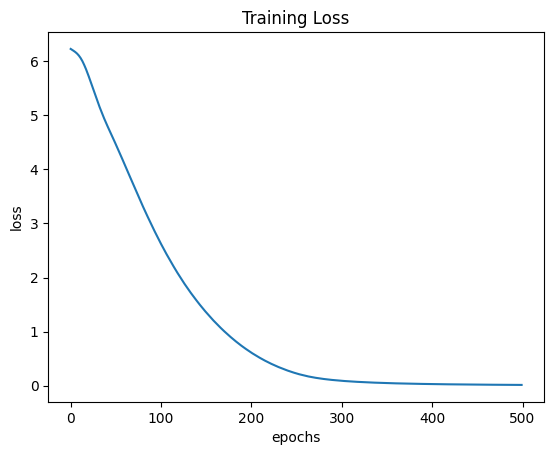

In [68]:
# Train model and plot results
model_cbow, epoch_losses = train_model(model_cbow, dataloader_cbow, criterion, optimizer, num_epochs=500)

plt.plot(epoch_losses)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Training Loss")
plt.show()

## Create t-SNE plot is showing semantically similar your words are based on what your CBOW model learned.

Embedding for 'hope': [ 0.9375518   0.55653656 -0.97741747 -1.1132793  -1.1567541   0.5698427
 -0.6880221   0.6096181   0.12553295  0.4321145   0.77149576 -1.1691545
 -0.15044962  1.0281059   0.90404415 -1.2296858   0.74209934 -1.4952091
  1.0671139  -1.180045    1.6529232  -1.1198684  -0.6753406  -1.1473775
  1.169155    0.76175344 -0.9776302   0.99317807 -0.8643462   0.8940679
 -0.88919693 -1.069902  ]


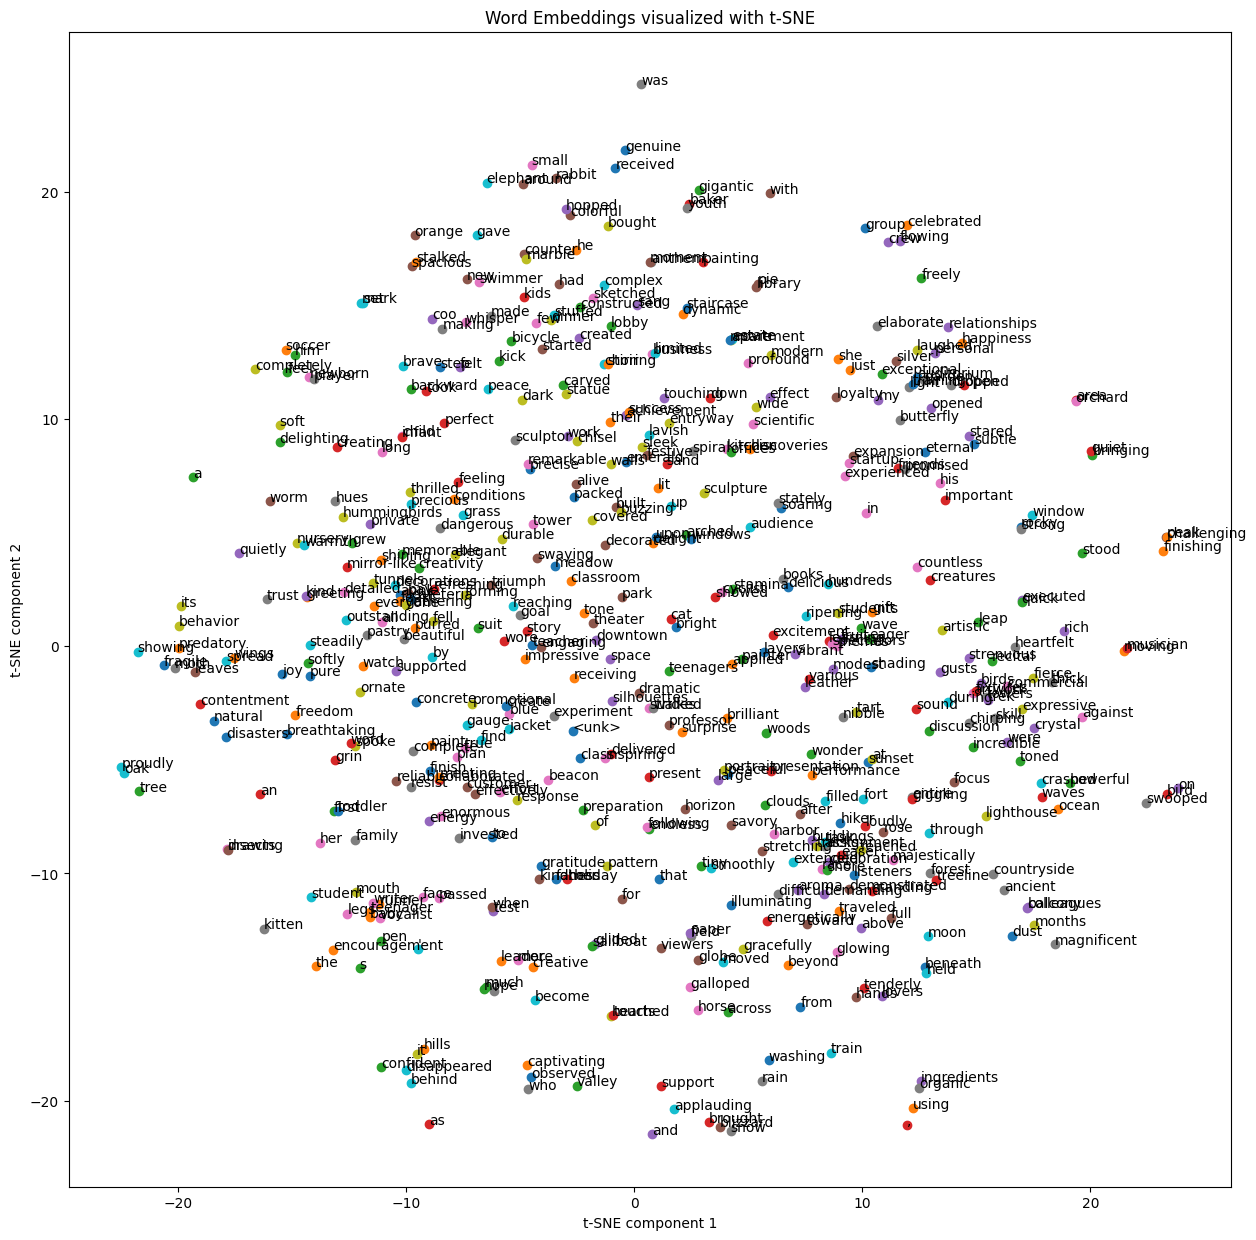

In [69]:
#Plot extracted embeddings

word_embeddings = model_cbow.embedding.weight.detach().cpu().numpy()

word = 'hope'  # Changed from 'baller' since it's not in your vocab
word_index = vocab.get_stoi()[word]
print(f"Embedding for '{word}':", word_embeddings[word_index])

plot_embeddings(word_embeddings, vocab)

In [75]:
#Show some sample predictions from the trained CBOW model and which training data sentences those predictions were from 

def complete_sentence():
    print("=== Sentence Completion with Training Data Sources ===")
    
    # Map predictions to their source sentences from training data
    training_sources = {
        ("i", "hope", "become", "much"): "I hope I become much more creative",
        ("the", "cat", "a", "bright"): "The cat stalked a bright orange butterfly in the garden",
        ("wore", "a", "blue", "jacket"): "He wore a dark blue jacket to the meeting", 
        ("had", "a", "grin", "on"): "She had a wide grin on her face when she passed the test"
    }
    
    test_cases = [
        (["i", "hope", "become", "much"], "should predict center word from actual training"),
        (["the", "cat", "a", "bright"], "from 'stalked' context"),
        (["wore", "a", "blue", "jacket"], "from jacket sentence"),
        (["had", "a", "grin", "on"], "from grin sentence")
    ]
    
    for context, description in test_cases:
        try:
            context_indices = [vocab[word] for word in context]
            with torch.no_grad():
                context_tensor = torch.tensor(context_indices, dtype=torch.int64).to(device)
                offsets = torch.tensor([0], dtype=torch.int64).to(device)
                output = model_cbow(context_tensor, offsets)
                predicted_idx = torch.argmax(output).item()
                predicted_word = vocab.get_itos()[predicted_idx]
                
            print(f"Context: {context} → Predicted: '{predicted_word}'")
            
            # Show the source training sentence
            context_key = tuple(context)
            if context_key in training_sources:
                source_sentence = training_sources[context_key]
                print(f"   Source: \"{source_sentence}\"")
                print(f"   Pattern: [{context[0]}, {context[1]}] + [{context[2]}, {context[3]}] → {predicted_word}")
            print()
            
        except KeyError as e:
            print(f"Word not in vocab: {e}")

complete_sentence()

=== Sentence Completion with Training Data Sources ===
Context: ['i', 'hope', 'become', 'much'] → Predicted: 'i'
   Source: "I hope I become much more creative"
   Pattern: [i, hope] + [become, much] → i

Context: ['the', 'cat', 'a', 'bright'] → Predicted: 'stalked'
   Source: "The cat stalked a bright orange butterfly in the garden"
   Pattern: [the, cat] + [a, bright] → stalked

Context: ['wore', 'a', 'blue', 'jacket'] → Predicted: 'dark'
   Source: "He wore a dark blue jacket to the meeting"
   Pattern: [wore, a] + [blue, jacket] → dark

Context: ['had', 'a', 'grin', 'on'] → Predicted: 'wide'
   Source: "She had a wide grin on her face when she passed the test"
   Pattern: [had, a] + [grin, on] → wide

